# Punto 2 - Kmeans - Miguel Rios Tangarife

Traemos las librerías que vamos a usar

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import zipfile
from scipy.io import loadmat
from urllib.request import urlretrieve
from os.path import isfile, isdir
import seaborn as sns; sns.set()
import glob
import matplotlib.image as img
from PIL import Image
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
#Descarga de las imagenes
def download_files():
    """
    Este metodo descarga los archivos de imagenes sino existen
    """
    path_tar = os.path.join("data",'faces.zip')
    if not isfile(path_tar):
        urlretrieve(
            'http://courses.media.mit.edu/2002fall/mas622j/proj/faces/rawdata.zip',
            path_tar)
    dest_path =  "data/faces"
    with zipfile.ZipFile(path_tar) as tar:
        tar.extractall(dest_path)
        tar.close()
download_files()

Indicamos donde están las imagenes

In [3]:
#En X ponemos las imagenes
d_name = 'C:\\GitHub\\Estadistica3_2023-2\\Tarea2\\data\\faces\\rawdata'
X = []

for nfile in os.listdir(d_name):
    bytes_read = open(os.path.join(d_name, nfile), "rb").read()
    img_data = Image.frombytes('L', (128, 128), bytes_read)
    X.append(np.array(img_data).flatten())

X = np.array(X)

In [4]:
#Trabajamos con 3993 imagenes y cada una tiene 16384 pixeles
X.shape

(3993, 16384)

In [5]:
# Reducción de dimensionalidad utilizando PCA para obtener las 5 primeras componentes
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

## K-mean sin librerías

In [6]:
'''
Algoritmo K-Means - sin librerías
n_clusters = Cantidad de clusters.
max_iters = Máximo de iteraciones que se permiten.
distances = Determinar a qué cluster pertenece cada punto.
labels = Almacena las asignaciones de cluster para cada punto de datos en el conjunto de datos de entrada.
centroids =  Los centroides son puntos que representan el centro de cada cluster.
'''

class KMeans:
    def __init__(self, n_clusters=7, max_iters=100):
        self.n_clusters = n_clusters
        self.max_iters = max_iters

    def fit(self, X):
        # Inicialización aleatoria de centroides
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for iteration in range(self.max_iters):
            # Asignar puntos al centroide más cercano
            distances = np.array([[absolute_distance(x, c) for c in self.centroids] for x in X])
            labels = np.argmin(distances, axis=1)

            # Actualizar los centroides
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])

            # Comprobar la convergencia
            if np.all(self.centroids == new_centroids):
                print(f"El algoritmo ha convergido en la iteración {iteration}.")  # Imprime el número de iteración
                break

            self.centroids = new_centroids

    def predict(self, X):
        distances = np.array([[absolute_distance(x, c) for c in self.centroids] for x in X])
        labels = np.argmin(distances, axis=1)
        return labels
        
#Funcion de la distancia de valor absoluto
def absolute_distance(point1, point2):
    return np.sum(np.abs(point1 - point2))      

In [7]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_pca)
predicted_labels = kmeans.predict(X_pca)

El algoritmo ha convergido en la iteración 38.


In [8]:
#Seleccionar las 4 caras más cercanas al centroide de cada cluster
selected_faces = []
for cluster_id in range(7):
    cluster_indices = np.where(predicted_labels == cluster_id)[0]
    cluster_centroid = kmeans.centroids[cluster_id]
    
    # Calcular distancias desde el centroide del cluster
    distances_to_centroid = [absolute_distance(X_pca[i], cluster_centroid) for i in cluster_indices]
    
    # Seleccionar las 4 caras más cercanas
    sorted_indices = np.argsort(distances_to_centroid)
    selected_faces.extend(cluster_indices[sorted_indices[:4]])

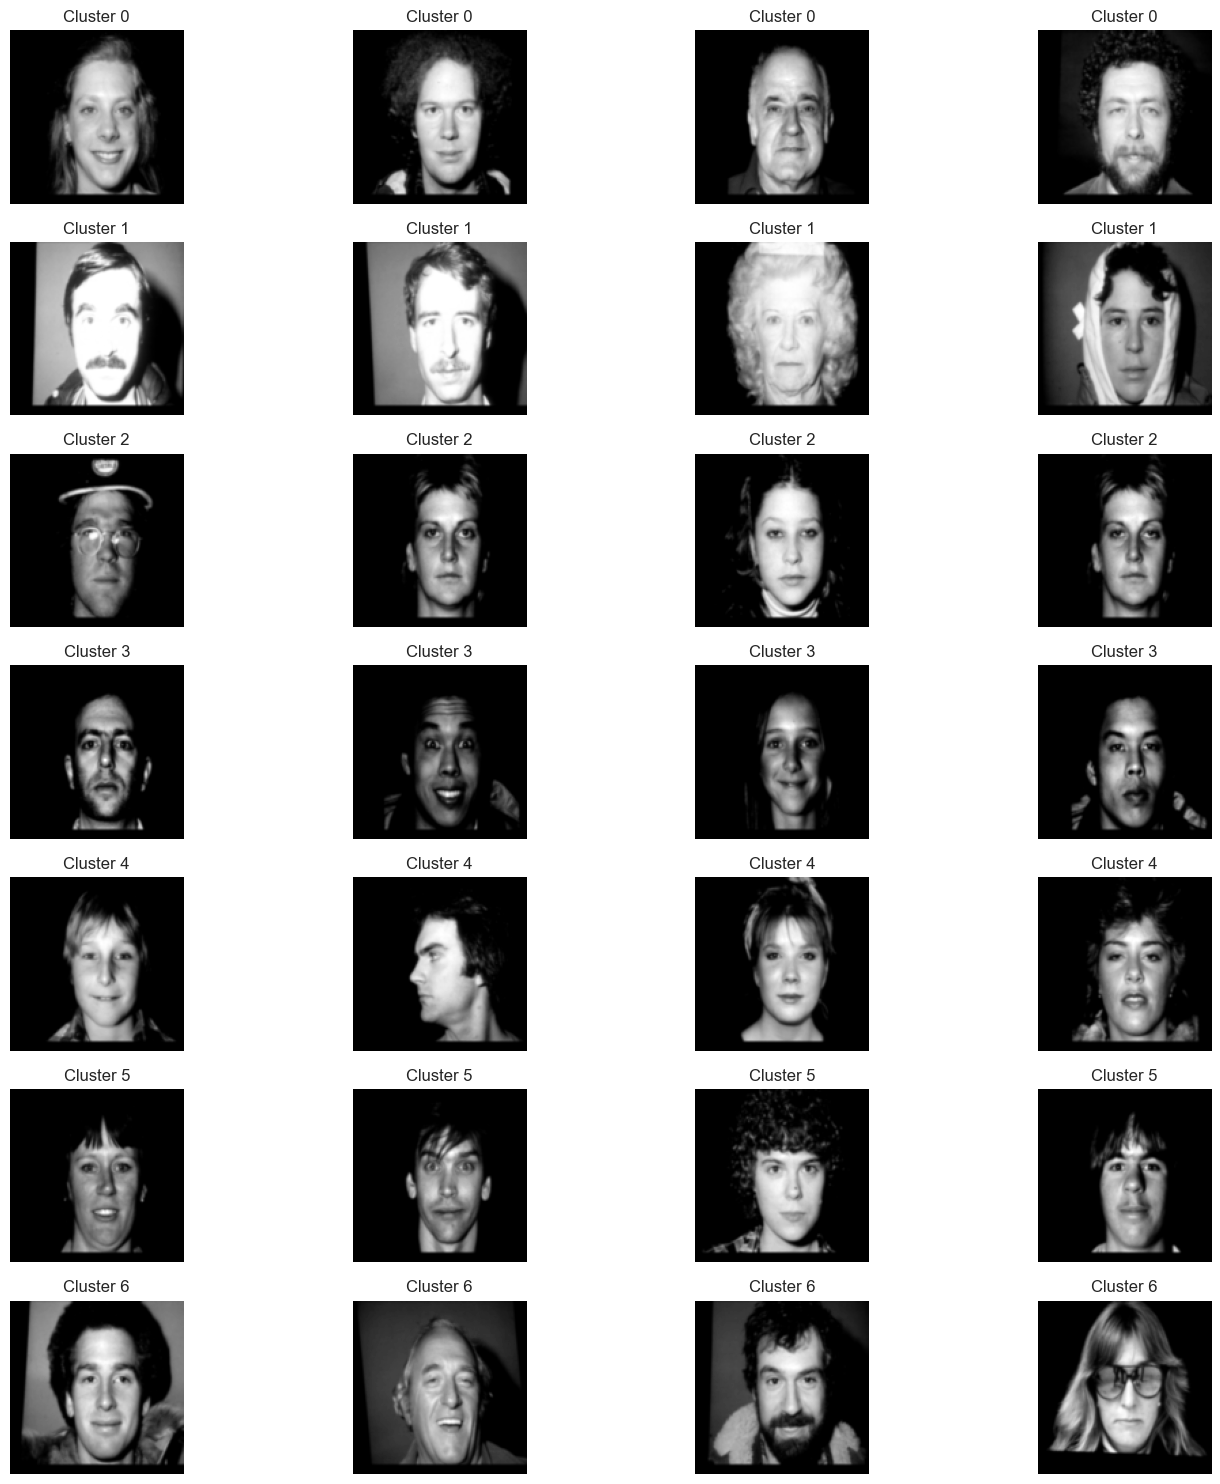

In [9]:
'''
Código para poder visualizar las imagenes obtenidas
'''
#Visualizar y describir las caras seleccionadas
plt.figure(figsize=(15, 15))
for i, face_idx in enumerate(selected_faces):
    plt.subplot(7, 4, i + 1)
    plt.imshow(X[face_idx].reshape(128, 128), cmap='gray')  # Usar X en lugar de data
    plt.title(f'Cluster {predicted_labels[face_idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Observaciones

De los diferentes clusters podemos decir:

- Cluster 0: Similitud en forma de la cara y en la frente mayormente
- Cluster 1: Similitud en que hay muchos pixeles blancos en las imagenes, saturación de luz en la imagen o cabello.
- Cluster 2: Similitud en las cejas y hay dos imagenes de la misma persona con leves diferencias faciales(Ojos más abiertos)
- Cluster 3: Se observa muchos pixeles con tonalidad oscura y muchas sombras en las caras de las personas, además de un fondo muy oscuro.
- Cluster 4: Las formas de los rostros son muy similares
- Cluster 5: Podemos observar como la frente esta cubierta por pelo y sus rasgos faciales son similares.
- Cluster 6: El fondo en tres de las imagenes es similar.

Después de aplicar K-Means y observar las imágenes, podemos apreciar que existen numerosos aspectos similares entre las imágenes. Esto indica que K-Means se está aplicando de manera efectiva.

En algunas imágenes, no es completamente claro por qué están relacionadas con las demás. Un ejemplo evidente es el clúster 6, donde la imagen de la mujer con gafas no parece tener similitudes con las otras imágenes.